\begin{aligned}
\text{Maximise} \quad & f(x_1, x_2, x_3) = 3x_1 + 5x_2 + 2x_3 \\
\text{subject to} \quad 
& 2x_1 + 3x_2 + x_3 \leq 12 \\
& x_1 + 2x_2 + 2x_3 \leq 10 \\
& 3x_1 + x_2 + 2x_3 \leq 8 \\
& 0 \leq x_1, x_2, x_3 \leq 10 \\
& x_1, x_2, x_3 \in \mathbb{Z}
\end{aligned}

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import milp, LinearConstraint, Bounds, linprog
from kan import *
import time

In [19]:
c = np.array([-3, -5, -2])
A = np.array([
    [2, 3, 1],
    [1, 2, 2],
    [3, 1, 2]
])
b = np.array([12, 10, 8])
bounds = Bounds([0, 0, 0], [10, 10, 10])

result = linprog(c, A_ub=A, b_ub=b, bounds=[(0, None), (0, None), (0, None)], method="highs")
x_lp = result.x
obj_lp = -result.fun
print(f"Relaxed LP Solution: x = {x_lp.round(4)}, Objective = {obj_lp:.2f}")

#IP solution
integrality = np.array([1, 1, 1])
milpResult = milp(
    c=c,
    constraints=LinearConstraint(A, lb=-np.inf, ub=b),
    bounds=bounds,
    integrality=integrality
)

xAnalytical = list(map(int, milpResult.x))
objAnalytical = -milpResult.fun
print(f"Integer MILP Solution: x = {xAnalytical}, Objective = {objAnalytical:.2f}")

Relaxed LP Solution: x = [0.  3.5 1.5], Objective = 20.50
Integer MILP Solution: x = [1, 3, 1], Objective = 20.00


In [ ]:
#generating samples
A = np.array([
    [2.0, 3.0, 1.0],
    [1.0, 2.0, 2.0],
    [3.0, 1.0, 2.0]
])
b = np.array([12.0, 10.0, 8.0])

A_tensor = torch.tensor(A, dtype=torch.float32)
b_tensor = torch.tensor(b, dtype=torch.float32)

def objectiveFn(x):
    return 3 * x[:, 0] + 5 * x[:, 1] + 2 * x[:, 2]

def generateFeasibleSamples(n=10000):
    data, target = [], []
    for i in range(n):
        x = torch.rand(3) * 10
        if torch.all(A_tensor @ x <= b_tensor):
            data.append(x)
            target.append(objectiveFn(x.unsqueeze(0)))
    return torch.stack(data), torch.stack(target)

In [21]:
#3 input nodes, 1 output
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 32), nn.ReLU(),
            nn.Linear(32, 32), nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)

mlpNRuns = 5
mlpEpochs = 20000
mlpAllLosses = []
mlpSummary = []
mlpAllEuclideanAccuracies = []
mlpAllObjectiveAccuracies = []
mlpAllCoordinates = []

for run in range(mlpNRuns):
    # torch.manual_seed(run)
    # np.random.seed(run)

    xTrain, yTrain = generateFeasibleSamples(1000)
    yTrain = (yTrain - yTrain.mean()) / yTrain.std()

    mlpModel = MLP()
    optimiser = optim.AdamW(mlpModel.parameters(), lr=0.001)
    runLosses = []
    mlpRunEuclideanAccuracies = []
    mlpRunObjectiveAccuracies = []
    mlpRunCoordinates = []
    startTime = time.time()

    for epoch in range(mlpEpochs):
        mlpModel.train()
        optimiser.zero_grad()
        predictions = mlpModel(xTrain).squeeze()
        mseLoss = torch.mean((predictions - yTrain.squeeze())**2)
        intPenalty = torch.mean((xTrain - xTrain.round())**2)
        feasibilityPenalty = torch.mean(torch.clamp(A_tensor @ xTrain.T - b_tensor[:, None], min=0))
        loss = mseLoss - 0.1 * predictions.mean() + 2 * intPenalty + feasibilityPenalty
        loss.backward()
        optimiser.step()
        runLosses.append(loss.item())

        with torch.no_grad():
            mlpModel.eval()
            predictions = mlpModel(xTrain).squeeze()
            bestPrediction = torch.argmax(predictions)
            mlpBestX = xTrain[bestPrediction].round()
            # while not torch.all(A_tensor @ mlpBestX <= b_tensor):
            #     mlpBestX -= 0.1 * (A_tensor @ mlpBestX - b_tensor).clamp(min=0)
            #     mlpBestX = mlpBestX.round()
            mlpRunCoordinates.append(mlpBestX)
            mlpBestVal = objectiveFn(mlpBestX.unsqueeze(0)).item()
            mlpBestX1 = mlpBestX[0].item()
            mlpBestX2 = mlpBestX[1].item()
            mlpBestX3 = mlpBestX[2].item()
            euclideanDistance = torch.norm(torch.tensor([mlpBestX1, mlpBestX2, mlpBestX3]) - torch.tensor([xAnalytical[0], xAnalytical[1], xAnalytical[2]])).item()
            mlpRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(mlpBestVal - objAnalytical)
            mlpRunObjectiveAccuracies.append(absoluteObjectiveDifference)

    endTime = time.time()
    mlpAllLosses.append(runLosses)
    mlpAllCoordinates.append(mlpRunCoordinates)
    mlpAllEuclideanAccuracies.append(mlpRunEuclideanAccuracies)
    mlpAllObjectiveAccuracies.append(mlpRunObjectiveAccuracies)
    mlpSummary.append({
        "objective": mlpBestVal,
        "finalLoss": runLosses[-1],
        "time": endTime - startTime,
        "x1": mlpBestX1,
        "x2": mlpBestX2,
        "x3": mlpBestX3
    })

    print(f"Run {run+1}: Best x1 = {mlpBestX1:.2f}, x2 = {mlpBestX2:.2f}, x3 = {mlpBestX3:.2f} → Obj = {mlpBestVal:.2f}, Loss = {runLosses[-1]:.4f}")

mlpObjectives = [r["objective"] for r in mlpSummary]
mlpLosses = [r["finalLoss"] for r in mlpSummary]
mlpTimes = [r["time"] for r in mlpSummary]
mlpX1Vals = [r["x1"] for r in mlpSummary]
mlpX2Vals = [r["x2"] for r in mlpSummary]
mlpX3Vals = [r["x3"] for r in mlpSummary]

print(f"Mean Objective Value: {np.mean(mlpObjectives):.4f} ± {np.std(mlpObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(mlpLosses):.4f} ± {np.std(mlpLosses):.4f}")
print(f"Mean Time:            {np.mean(mlpTimes):.4f}s ± {np.std(mlpTimes):.4f}s")


Run 1: Best x1 = 1.00, x2 = 3.00, x3 = 1.00 → Obj = 20.00, Loss = 0.1712
Run 2: Best x1 = 1.00, x2 = 3.00, x3 = 1.00 → Obj = 20.00, Loss = 0.1219
Run 3: Best x1 = 1.00, x2 = 3.00, x3 = 1.00 → Obj = 20.00, Loss = 0.1213
Run 4: Best x1 = 0.00, x2 = 3.00, x3 = 1.00 → Obj = 17.00, Loss = 0.1624
Run 5: Best x1 = 0.00, x2 = 2.00, x3 = 2.00 → Obj = 14.00, Loss = 0.1411
Mean Objective Value: 18.2000 ± 2.4000
Mean Final Loss:      0.1436 ± 0.0204
Mean Time:            76.1895s ± 5.2749s


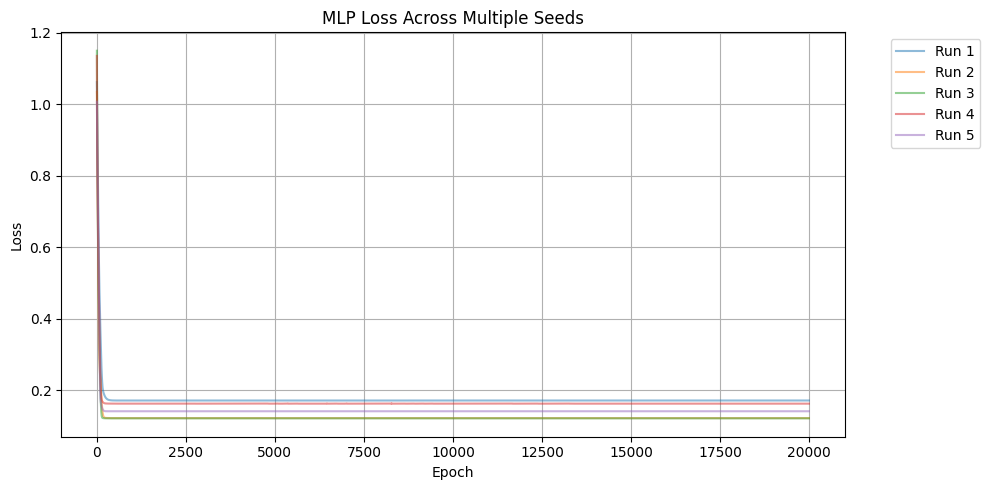

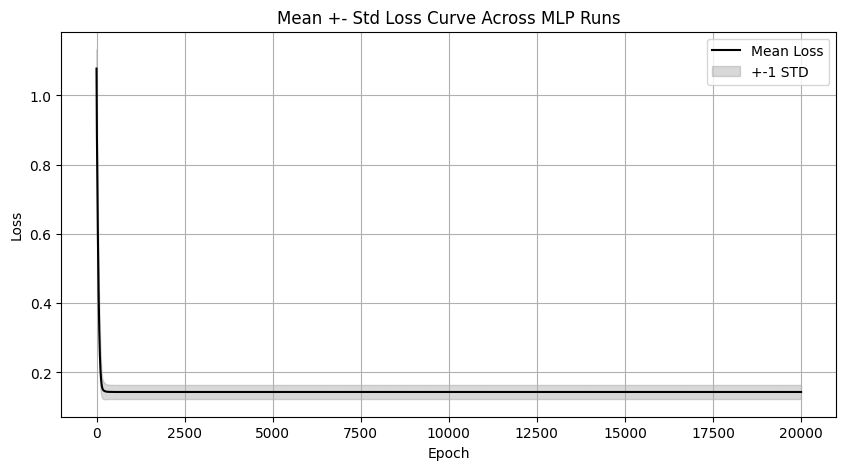

In [22]:
#loss curve
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP Loss Across Multiple Seeds")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

mlpLossArray = np.array(mlpAllLosses)
mlpMeanLoss = np.mean(mlpLossArray, axis=0)
mlpStdLoss = np.std(mlpLossArray, axis=0)

#mean and std loss
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="Mean Loss", color='black')
plt.fill_between(range(mlpEpochs), mlpMeanLoss - mlpStdLoss, mlpMeanLoss + mlpStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Loss Curve Across MLP Runs")
plt.grid(True)
plt.legend()
plt.show()

#mlpModel
#mlpObjectives
#mlpLosses
#mlpTimes
#mlpAllLosses
#mlpMeanLoss
#mlpStdLoss
#mlpX1Vals
#mlpX2Vals
#mlpX3Vals

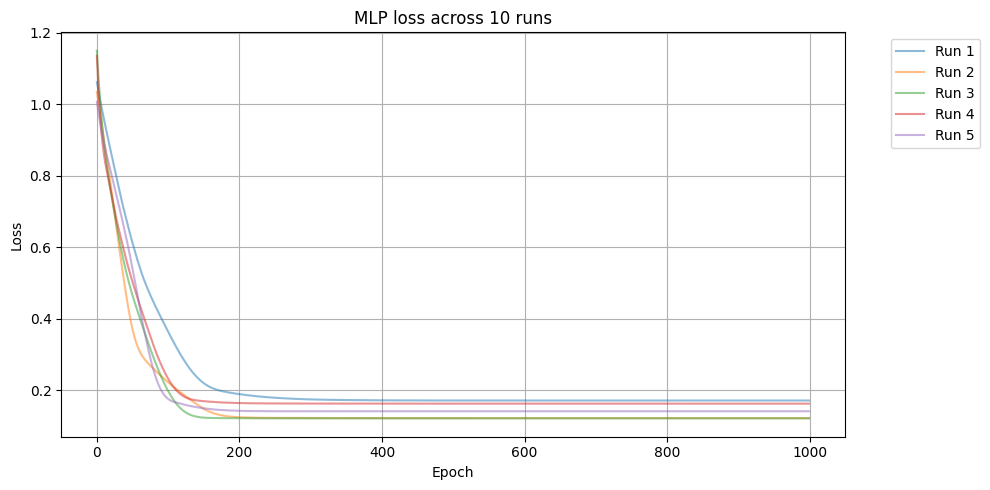

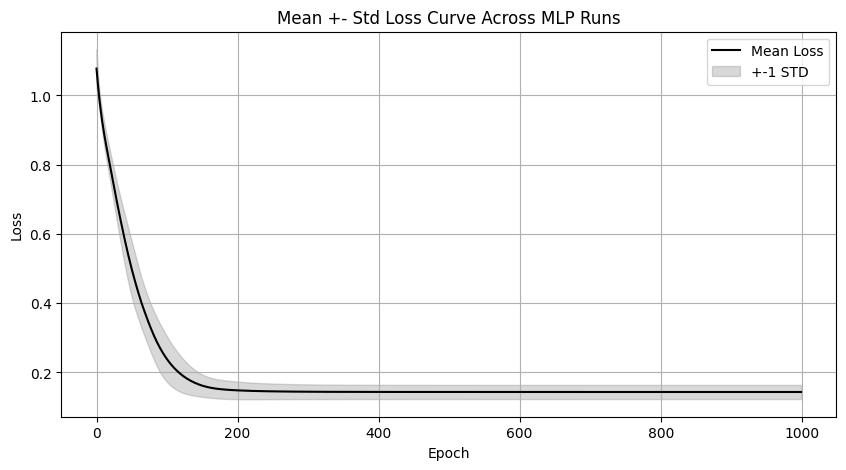

In [23]:
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(mlpAllLosses):
    plt.plot(runLoss[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP loss across 10 runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss[:1000], label="Mean Loss", color='black')
plt.fill_between(range(1000), mlpMeanLoss[:1000] - mlpStdLoss[:1000], mlpMeanLoss[:1000] + mlpStdLoss[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Loss Curve Across MLP Runs")
plt.grid(True)
plt.legend()
plt.show()

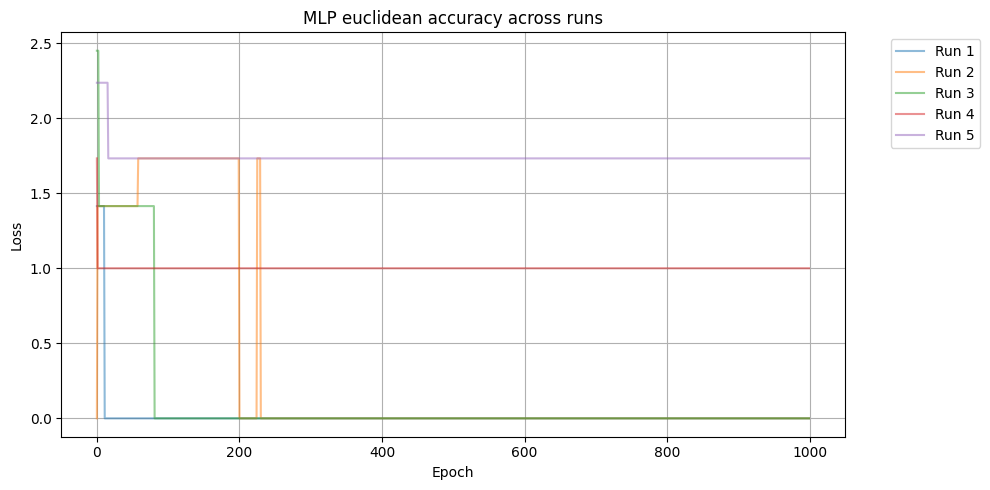

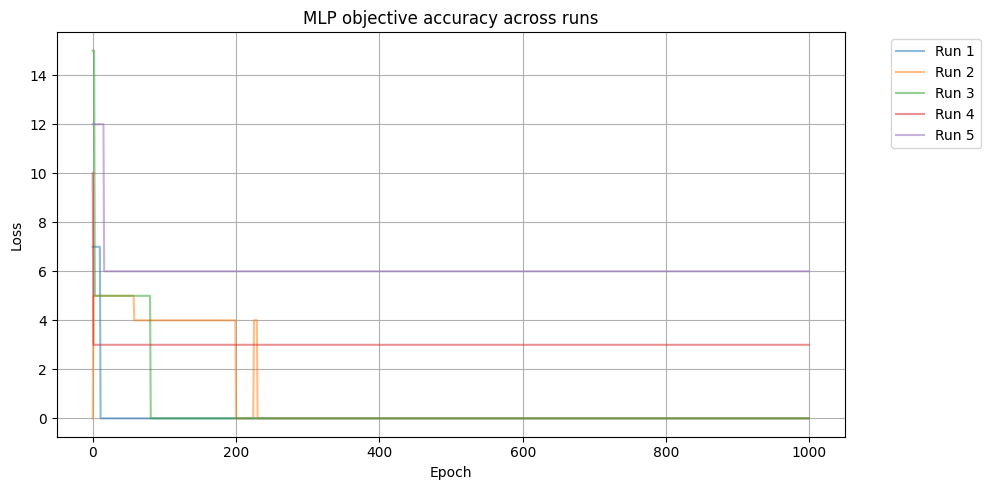

In [3]:
#euclidean accuracy over all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllEuclideanAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP euclidean accuracy across runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#objective accuracy over all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(mlpAllObjectiveAccuracies):
    plt.plot(runAccuracy[:1000], label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP objective accuracy across runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


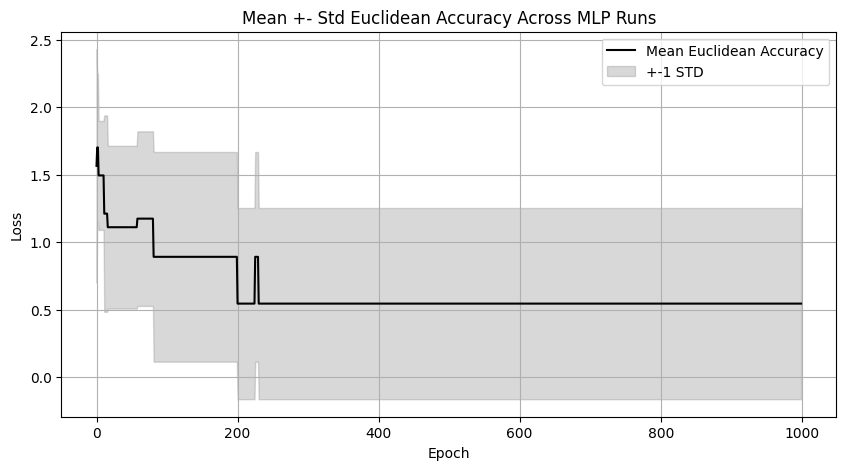

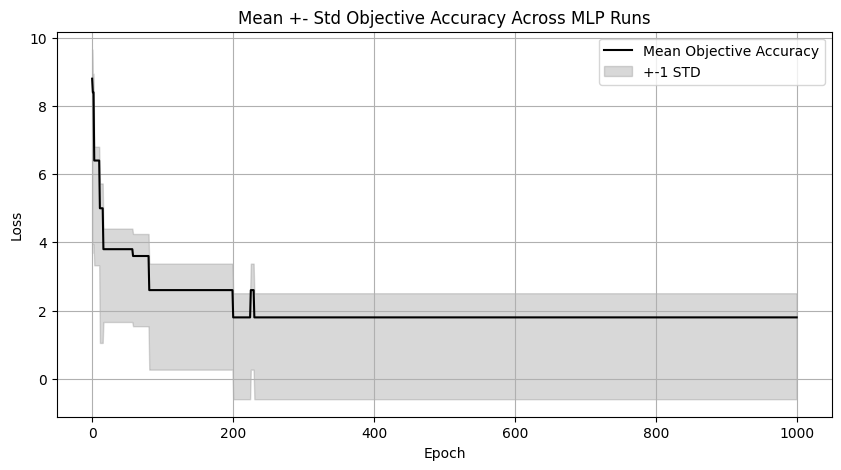

In [25]:
mlpEuclideanAccuracyArray = np.array(mlpAllEuclideanAccuracies)
mlpMeanEuclideanAccuracy = np.mean(mlpEuclideanAccuracyArray, axis=0)
mlpStdEuclideanAccuracy = np.std(mlpEuclideanAccuracyArray, axis=0)

#mean and std of euclidean accuracy
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanEuclideanAccuracy[:1000], label="Mean Euclidean Accuracy", color='black')
plt.fill_between(range(1000), mlpMeanEuclideanAccuracy[:1000] - mlpStdEuclideanAccuracy[:1000], mlpMeanEuclideanAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Euclidean Accuracy Across MLP Runs")
plt.grid(True)
plt.legend()
plt.show()

mlpObjectiveAccuracyArray = np.array(mlpAllObjectiveAccuracies)
mlpMeanObjectiveAccuracy = np.mean(mlpObjectiveAccuracyArray, axis=0)
mlpStdObjectiveAccuracy = np.std(mlpObjectiveAccuracyArray, axis=0)

#mean and std of objective accuracy
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanObjectiveAccuracy[:1000], label="Mean Objective Accuracy", color='black')
plt.fill_between(range(1000), mlpMeanObjectiveAccuracy[:1000] - mlpStdObjectiveAccuracy[:1000], mlpMeanObjectiveAccuracy[:1000] + mlpStdEuclideanAccuracy[:1000],
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Objective Accuracy Across MLP Runs")
plt.grid(True)
plt.legend()
plt.show()

In [36]:
kanNRuns = 5
kanEpochs = 1000
kanAllLosses = []
kanSummary = []
kanAllEuclideanAccuracies = []
kanAllObjectiveAccuracies = []
kanAllCoordinates = []

gridSizes = [5]

for run in range(kanNRuns):
    torch.manual_seed(run)
    np.random.seed(run)

    xTrain, yTrain = generateFeasibleSamples(1000)
    yTrain = (yTrain - yTrain.mean()) / yTrain.std()

    kanModel = KAN(width=[3, 6, 6, 1], grid=5, k=3, seed=run)
    startTime = time.time()
    

    optimiser = optim.AdamW(kanModel.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=500, gamma=0.5)

    runLosses = []
    kanRunEuclideanAccuracies = []
    kanRunObjectiveAccuracies = []
    kanRunCoordinates = []

    for epoch in range(kanEpochs):
        kanModel.train()
        optimiser.zero_grad()

        predictions = kanModel(xTrain).squeeze()
        mse = torch.mean((predictions - yTrain.squeeze())**2)
        intPenalty = torch.mean((xTrain - xTrain.round())**2)
        feasibilityPenalty = torch.mean(torch.clamp(A_tensor @ xTrain.T - b_tensor[:, None], min=0))
        loss = mse - 0.1 * predictions.mean() + 2 * intPenalty + feasibilityPenalty
        loss.backward()
        optimiser.step()
        scheduler.step()

        runLosses.append(loss.item())

        with torch.no_grad():
            kanModel.eval()
            predictions = kanModel(xTrain).squeeze()
            bestPrediction = torch.argmax(predictions)
            kanBestX = xTrain[bestPrediction].round()

            # while not torch.all(A_tensor @ kanBestX <= b_tensor):
            #     kanBestX -= 0.1 * (A_tensor @ kanBestX - b_tensor).clamp(min=0)
            #     kanBestX = kanBestX.round()
            kanRunCoordinates.append(kanBestX)
            bestVal = objectiveFn(kanBestX.unsqueeze(0)).item()
            kanBestXVals = kanBestX.cpu().numpy().astype(int)
            euclideanDistance = torch.norm(kanBestX - torch.tensor([xAnalytical[0], xAnalytical[1], xAnalytical[2]])).item()
            kanRunEuclideanAccuracies.append(euclideanDistance)
            absoluteObjectiveDifference = abs(bestVal - objAnalytical)
            kanRunObjectiveAccuracies.append(absoluteObjectiveDifference)

    endTime = time.time()
    kanAllLosses.append(runLosses)
    kanAllCoordinates.append(kanRunCoordinates)
    kanAllEuclideanAccuracies.append(kanRunEuclideanAccuracies)
    kanAllObjectiveAccuracies.append(kanRunObjectiveAccuracies)
    kanSummary.append({
        "objective": bestVal,
        "finalLoss": runLosses[-1],
        "time": endTime - startTime,
        "x1": kanBestXVals[0],
        "x2": kanBestXVals[1],
        "x3": kanBestXVals[2]
    })

    print(f"Run {run+1}: Best x1 = {kanBestXVals[0]}, x2 = {kanBestXVals[1]}, x3 = {kanBestXVals[2]} => Objective = {bestVal:.4f}, Loss = {runLosses[-1]:.4f}")

kanObjectives = [r["objective"] for r in kanSummary]
kanLosses = [r["finalLoss"] for r in kanSummary]
kanTimes = [r["time"] for r in kanSummary]
kanX1Vals = [r["x1"] for r in kanSummary]
kanX2Vals = [r["x2"] for r in kanSummary]
kanX3Vals = [r["x3"] for r in kanSummary]

kanLossArray = np.array(kanAllLosses)
kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

print(f"Mean Objective Value: {np.mean(kanObjectives):.4f} +- {np.std(kanObjectives):.4f}")
print(f"Mean Final Loss:      {np.mean(kanLosses):.4f} +- {np.std(kanLosses):.4f}")
print(f"Mean Time:            {np.mean(kanTimes):.4f}s +- {np.std(kanTimes):.4f}s")

#kanModel
#kanObjectives
#kanLosses
#kanTimes
#kanX1Vals
#kanX2Vals
#kanX3Vals
#kanAllLosses
#kanMeanLoss
#kanStdLoss

checkpoint directory created: ./model
saving model version 0.0
Run 1: Best x1 = 1, x2 = 3, x3 = 0 => Objective = 18.0000, Loss = 0.1450
checkpoint directory created: ./model
saving model version 0.0
Run 2: Best x1 = 1, x2 = 3, x3 = 1 => Objective = 20.0000, Loss = 0.2194
checkpoint directory created: ./model
saving model version 0.0
Run 3: Best x1 = 0, x2 = 2, x3 = 2 => Objective = 14.0000, Loss = 0.1469
checkpoint directory created: ./model
saving model version 0.0
Run 4: Best x1 = 0, x2 = 3, x3 = 1 => Objective = 17.0000, Loss = 0.1644
checkpoint directory created: ./model
saving model version 0.0
Run 5: Best x1 = 1, x2 = 3, x3 = 1 => Objective = 20.0000, Loss = 0.1782
Mean Objective Value: 17.8000 +- 2.2271
Mean Final Loss:      0.1708 +- 0.0272
Mean Time:            63.3337s +- 4.6045s


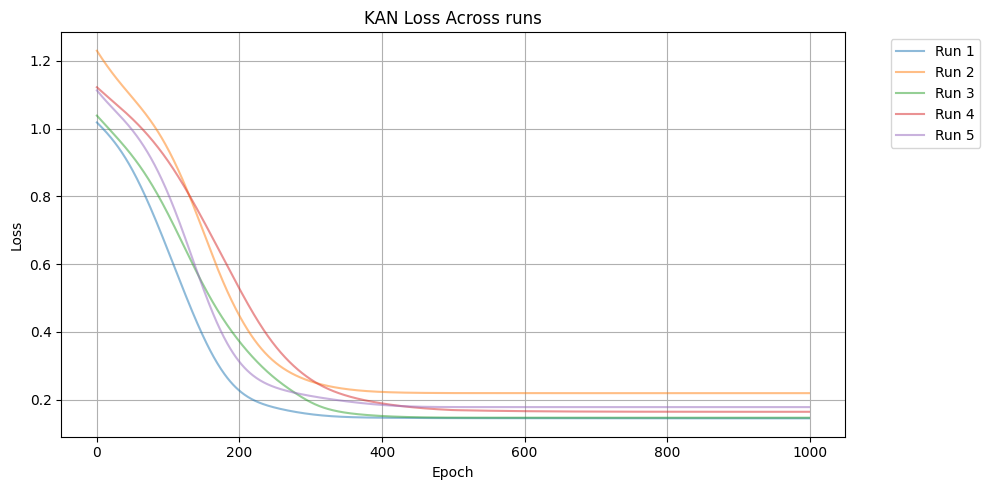

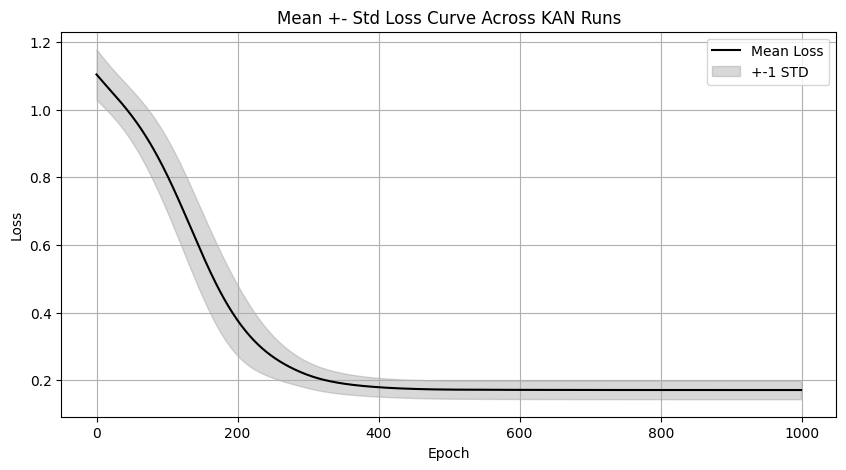

In [ ]:

#loss curve
plt.figure(figsize=(10, 5))
for i, runLoss in enumerate(kanAllLosses):
    plt.plot(runLoss, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("KAN Loss Across runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#mean +- std of loss
kanLossArray = np.array(kanAllLosses)
kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(kanMeanLoss, label="Mean Loss", color='black')
plt.fill_between(range(1000), kanMeanLoss - kanStdLoss, kanMeanLoss + kanStdLoss,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Loss Curve Across KAN Runs")
plt.grid(True)
plt.legend()
plt.show()

#kanModel
#kanObjectives
#kanLosses
#kanTimes
#kanX1Vals
#kanX2Vals
#kanAllLosses
#kanMeanLoss
#kanStdLoss

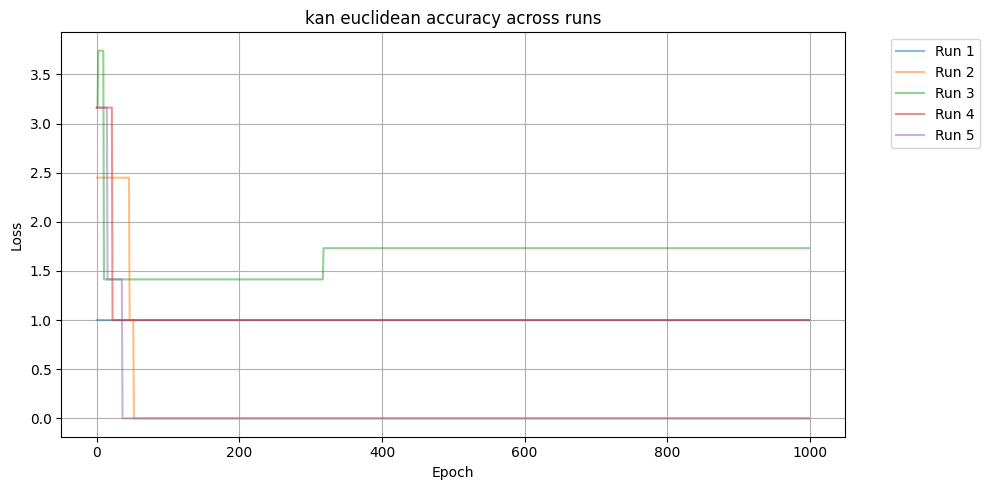

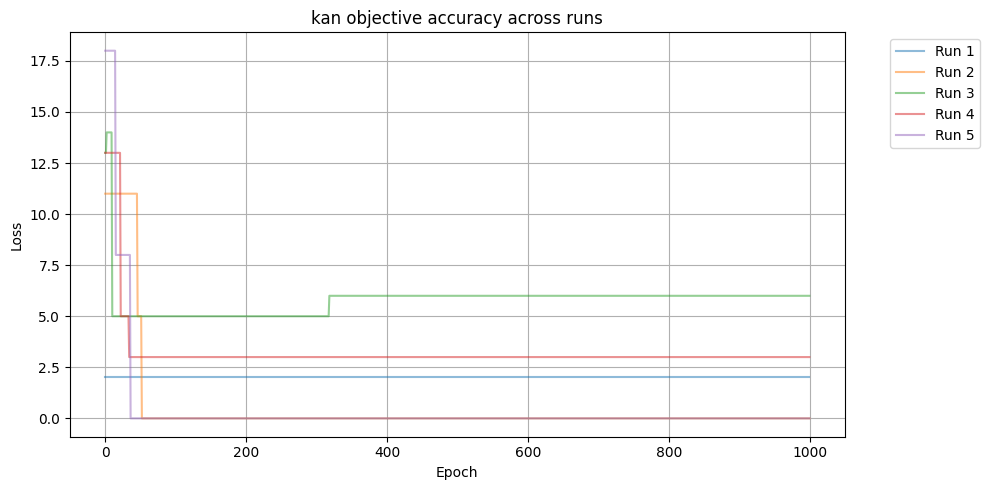

In [4]:
#kan euclidean accuracy across all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllEuclideanAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("kan euclidean accuracy across runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#kan objective accuracy across all runs
plt.figure(figsize=(10, 5))
for i, runAccuracy in enumerate(kanAllObjectiveAccuracies):
    plt.plot(runAccuracy, label=f"Run {i+1}", alpha=0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("kan objective accuracy across runs")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



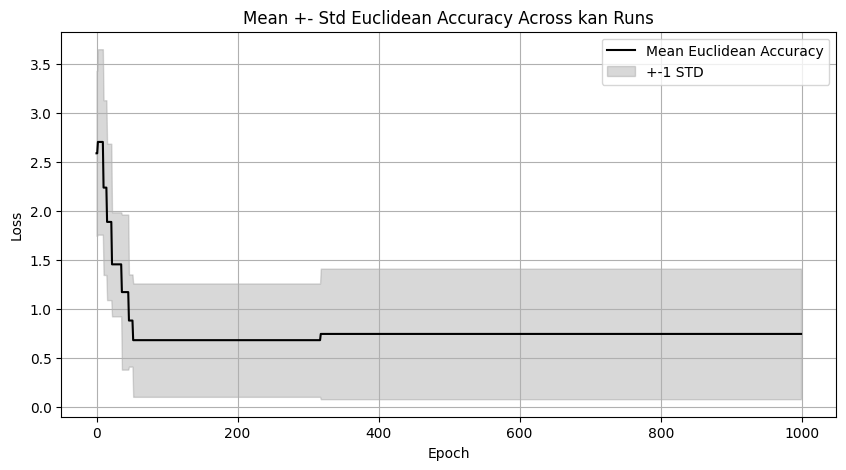

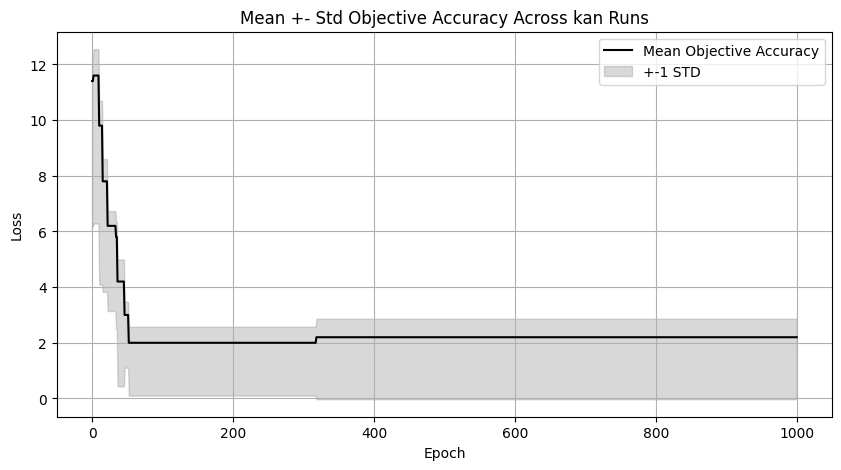

In [39]:
#kan mean and std of euclidean accuracy
kanEuclideanAccuracyArray = np.array(kanAllEuclideanAccuracies)
kanMeanEuclideanAccuracy = np.mean(kanEuclideanAccuracyArray, axis=0)
kanStdEuclideanAccuracy = np.std(kanEuclideanAccuracyArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(kanMeanEuclideanAccuracy, label="Mean Euclidean Accuracy", color='black')
plt.fill_between(range(kanEpochs), kanMeanEuclideanAccuracy - kanStdEuclideanAccuracy, kanMeanEuclideanAccuracy + kanStdEuclideanAccuracy,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Euclidean Accuracy Across kan Runs")
plt.grid(True)
plt.legend()
plt.show()

#kan mean and std of objective accuracy
kanObjectiveAccuracyArray = np.array(kanAllObjectiveAccuracies)
kanMeanObjectiveAccuracy = np.mean(kanObjectiveAccuracyArray, axis=0)
kanStdObjectiveAccuracy = np.std(kanObjectiveAccuracyArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(kanMeanObjectiveAccuracy, label="Mean Objective Accuracy", color='black')
plt.fill_between(range(kanEpochs), kanMeanObjectiveAccuracy - kanStdObjectiveAccuracy, kanMeanObjectiveAccuracy + kanStdEuclideanAccuracy,
                 color='gray', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Objective Accuracy Across kan Runs")
plt.grid(True)
plt.legend()
plt.show()

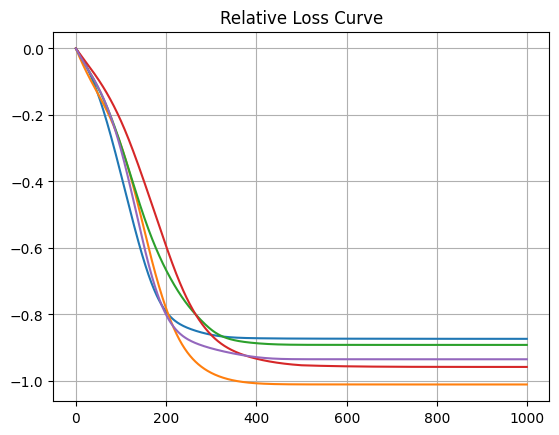

In [40]:
#curve to show relative loss from initial position.
#this is because the loss function results in losses that are very small, making it hard to visualise the raw values
for i, runLoss in enumerate(kanAllLosses):
    initialLoss = runLoss[0]
    relativeLoss = [l - initialLoss for l in runLoss]
    plt.plot(relativeLoss)
plt.title("Relative Loss Curve")
plt.grid()
plt.show()

<b>Saving results to pickle files</b>  
If the values in the notebook are ever lost, I can just load the existing results instead of running everything again.  
with open('mlpResults.pkl', 'rb') as f:  
    mlpResults = pickle.load(f)  
with open('kanResults.pkl', 'rb') as f:  
    kanResults = pickle.load(f)  

In [41]:
import pickle

mlpResults = {
    "mlpObjectives": mlpObjectives,
    "mlpAllLosses": mlpAllLosses,
    "mlpTimes": mlpTimes,
    "mlpSummary": mlpSummary,
    "mlpAllCoordinates": mlpAllCoordinates,
    "mlpAllEuclideanAccuracies": mlpAllEuclideanAccuracies,
    "mlpAllObjectiveAccuracies": mlpAllObjectiveAccuracies
}

with open('mlpResults.pkl', 'wb') as f:
    pickle.dump(mlpResults, f)

kanResults = {
    "kanObjectives": kanObjectives,
    "kanAllLosses": kanAllLosses,
    "kanTimes": kanTimes,
    "kanSummary": kanSummary,
    "kanAllCoordinates": kanAllCoordinates,
    "kanAllEuclideanAccuracies": kanAllEuclideanAccuracies,
    "kanAllObjectiveAccuracies": kanAllObjectiveAccuracies
}

with open('kanResults.pkl', 'wb') as f:
    pickle.dump(kanResults, f)

In [42]:
#getting convergence speed
def computeConvergenceSpeed(allLosses, thresholdRatio=0.05):
    speeds = []
    for lossCurve in allLosses:
        finalLoss = lossCurve[-1]
        threshold = finalLoss * (1 + thresholdRatio)
        for i, loss in enumerate(lossCurve):
            if loss <= threshold:
                speeds.append(i)
                break
    return speeds

mlpConvergence = computeConvergenceSpeed(mlpAllLosses)
kanConvergence = computeConvergenceSpeed(kanAllLosses)

#model complexity - this is based on the parameter count for each
mlpParamCount = sum(p.numel() for p in mlpModel.parameters())
kanParamCount = sum(p.numel() for p in kanModel.parameters())

mlpBestObjective = np.max(mlpObjectives)
kanBestObjective = np.max(kanObjectives)



In [43]:
#metric comparison table
comparisonData = {
    "Metric": [
        "Mean Objective Value",
        "Std Objective Value",
        "Best Objective Value",
        "Mean Final Loss",
        "Std Final Loss",
        "Mean Time (s)",
        "Std Time (s)",
        "Mean Convergence Epoch",
        "Std Convergence Epoch",
        "Model Parameters"
    ],
    "MLP": [
        np.mean(mlpObjectives),
        np.std(mlpObjectives),
        mlpBestObjective,
        np.mean(mlpLosses),
        np.std(mlpLosses),
        np.mean(mlpTimes),
        np.std(mlpTimes),
        np.mean(mlpConvergence),
        np.std(mlpConvergence),
        mlpParamCount
    ],
    "KAN": [
        np.mean(kanObjectives),
        np.std(kanObjectives),
        kanBestObjective,
        np.mean(kanLosses),
        np.std(kanLosses),
        np.mean(kanTimes),
        np.std(kanTimes),
        np.mean(kanConvergence),
        np.std(kanConvergence),
        kanParamCount
    ]
}

comparisonDf = pd.DataFrame(comparisonData)
display(comparisonDf)


,Metric,MLP,KAN
0,Mean Objective Value,18.200000,17.800000
1,Std Objective Value,2.400000,2.227106
2,Best Objective Value,20.000000,20.000000
3,Mean Final Loss,0.143592,0.170767
4,Std Final Loss,0.020437,0.027176
5,Mean Time (s),76.189490,63.333682
6,Std Time (s),5.274876,4.604491
7,Mean Convergence Epoch,172.000000,384.200000
8,Std Convergence Epoch,38.848423,49.849373
9,Model Parameters,1217.000000,1192.000000


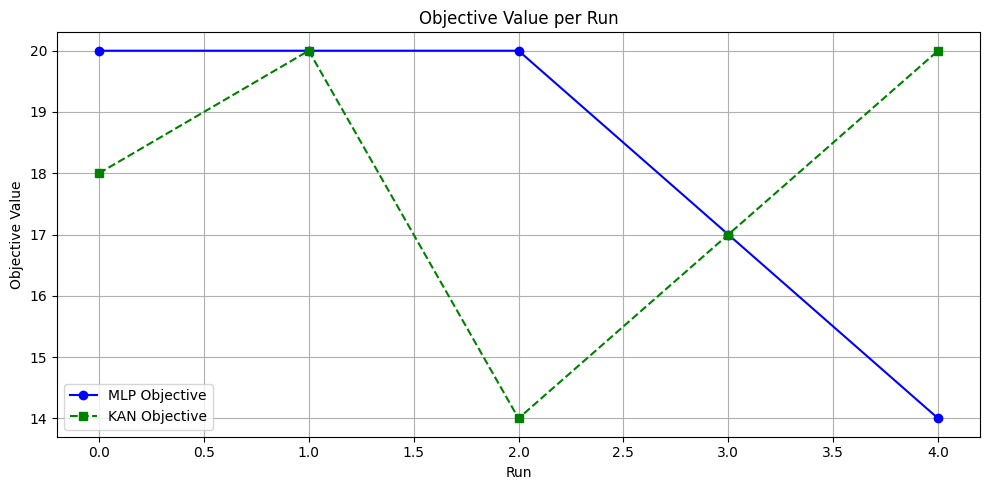

In [44]:
#objective value across models
plt.figure(figsize=(10, 5))
plt.plot(mlpObjectives, 'o-', label="MLP Objective", color='blue')
plt.plot(kanObjectives, 's--', label="KAN Objective", color='green')
plt.title("Objective Value per Run")
plt.xlabel("Run")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

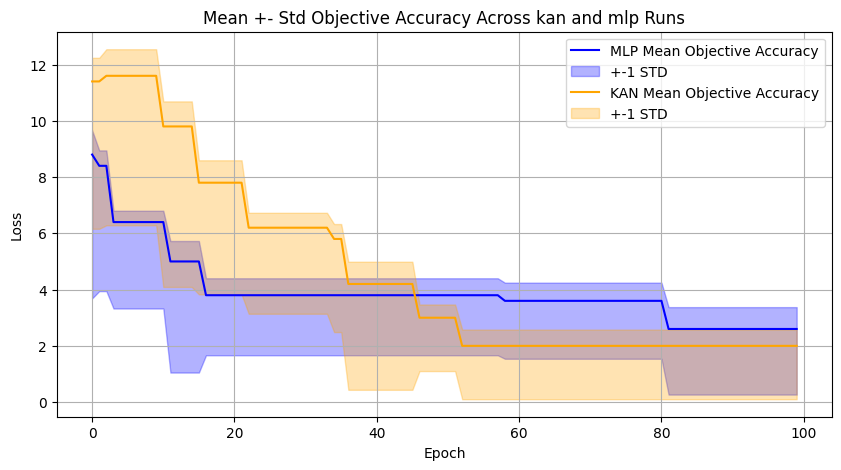

In [45]:
#objective accuracy comparison
epochLimit = 100
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanObjectiveAccuracy[:epochLimit], label="MLP Mean Objective Accuracy", color='blue')
plt.fill_between(range(epochLimit), mlpMeanObjectiveAccuracy[:epochLimit] - mlpStdObjectiveAccuracy[:epochLimit], mlpMeanObjectiveAccuracy[:epochLimit] + mlpStdEuclideanAccuracy[:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(kanMeanObjectiveAccuracy[:epochLimit], label="KAN Mean Objective Accuracy", color='orange')
plt.fill_between(range(epochLimit), kanMeanObjectiveAccuracy[:epochLimit] - kanStdObjectiveAccuracy[:epochLimit], kanMeanObjectiveAccuracy[:epochLimit] + kanStdEuclideanAccuracy[:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Objective Accuracy Across kan and mlp Runs")
plt.grid(True)
plt.legend()
plt.show()

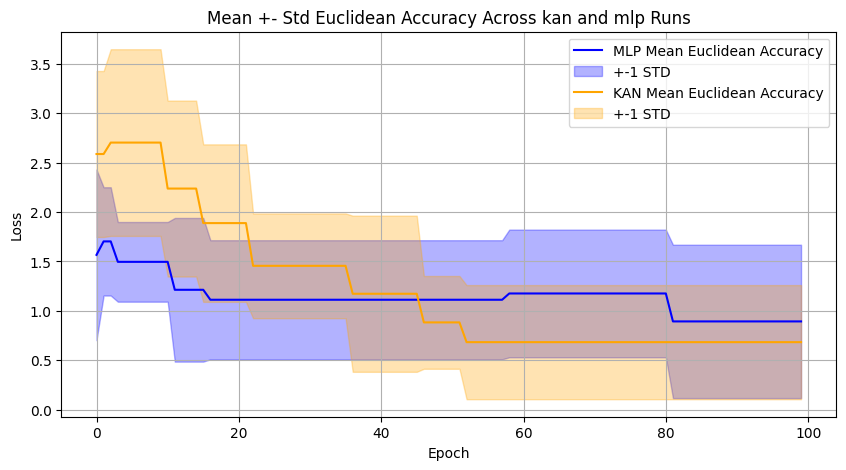

In [46]:
#euclidean accuracy comparison
epochLimit = 100
plt.figure(figsize=(10, 5))
plt.plot(mlpMeanEuclideanAccuracy[:epochLimit], label="MLP Mean Euclidean Accuracy", color='blue')
plt.fill_between(range(epochLimit), mlpMeanEuclideanAccuracy[:epochLimit] - mlpStdEuclideanAccuracy[:epochLimit], mlpMeanEuclideanAccuracy[:epochLimit] + mlpStdEuclideanAccuracy[:epochLimit],
                 color='blue', alpha=0.3, label="+-1 STD")
plt.plot(kanMeanEuclideanAccuracy[:epochLimit], label="KAN Mean Euclidean Accuracy", color='orange')
plt.fill_between(range(epochLimit), kanMeanEuclideanAccuracy[:epochLimit] - kanStdEuclideanAccuracy[:epochLimit], kanMeanEuclideanAccuracy[:epochLimit] + kanStdEuclideanAccuracy[:epochLimit],
                 color='orange', alpha=0.3, label="+-1 STD")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Euclidean Accuracy Across kan and mlp Runs")
plt.grid(True)
plt.legend()
plt.show()

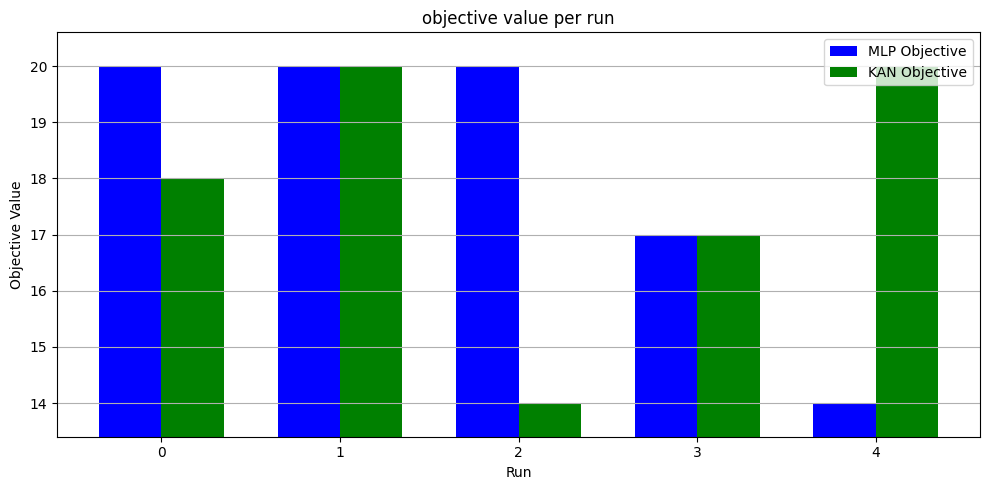

In [47]:
#bar chart comparison of objective values
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpObjectives, width=bar_width, label="MLP Objective", color='blue')
plt.bar(runs + offset, kanObjectives, width=bar_width, label="KAN Objective", color='green')

plt.title("objective value per run")
plt.xlabel("Run")
plt.ylabel("Objective Value")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
minVal = min(min(mlpObjectives), min(kanObjectives))
maxVal = max(max(mlpObjectives), max(kanObjectives))
padding = (maxVal - minVal) * 0.1
plt.ylim(minVal - padding, maxVal + padding)
plt.tight_layout()
plt.show()

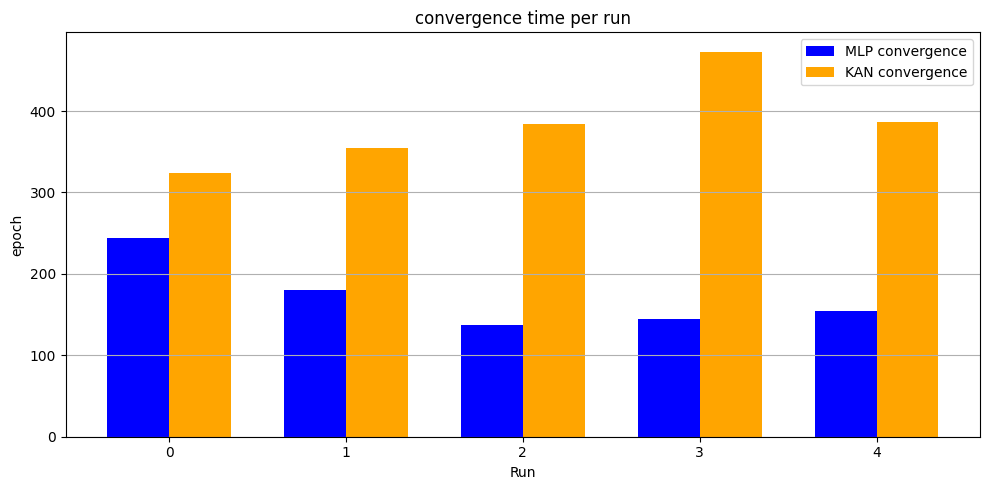

In [48]:
#convergence time comparison
runs = np.arange(len(mlpObjectives))
bar_width = 0.35
offset = bar_width / 2
plt.figure(figsize=(10, 5))
plt.bar(runs - offset, mlpConvergence, width=bar_width, label="MLP convergence", color='blue')
plt.bar(runs + offset, kanConvergence, width=bar_width, label="KAN convergence", color='orange')

plt.title("convergence time per run")
plt.xlabel("Run")
plt.ylabel("epoch")
plt.xticks(runs)
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

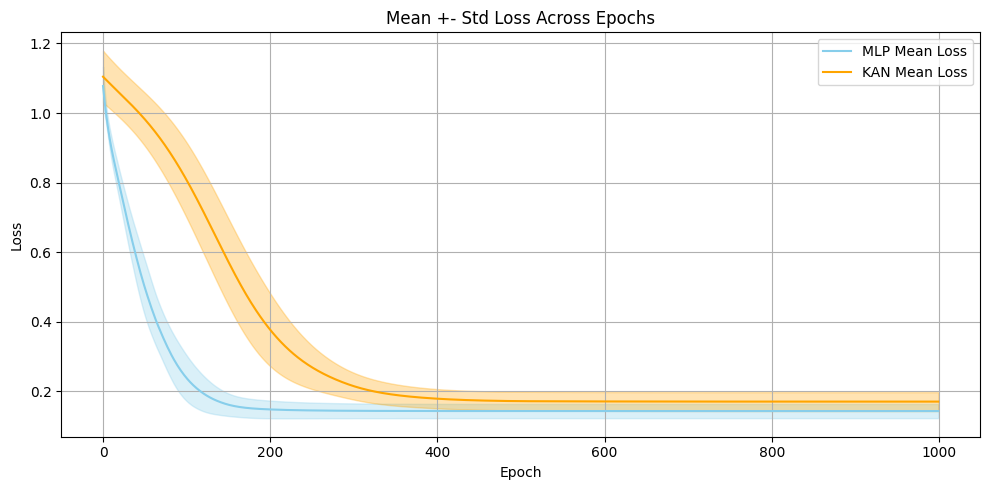

In [49]:
#loss comparison
mlpLossArray = np.array(mlpAllLosses)
kanLossArray = np.array(kanAllLosses)

mlpMeanLoss = np.mean(mlpLossArray, axis=0)[:1000]
mlpStdLoss = np.std(mlpLossArray, axis=0)[:1000]

kanMeanLoss = np.mean(kanLossArray, axis=0)
kanStdLoss = np.std(kanLossArray, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mlpMeanLoss, label="MLP Mean Loss", color='skyblue')
plt.fill_between(range(len(mlpMeanLoss)),
                 mlpMeanLoss - mlpStdLoss,
                 mlpMeanLoss + mlpStdLoss,
                 alpha=0.3, color='skyblue')

plt.plot(kanMeanLoss, label="KAN Mean Loss", color='orange')
plt.fill_between(range(len(kanMeanLoss)),
                 kanMeanLoss - kanStdLoss,
                 kanMeanLoss + kanStdLoss,
                 alpha=0.3, color='orange')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Mean +- Std Loss Across Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
mlpBestPrediction = np.argmax(mlpObjectives)
kanBestPrediction = np.argmax(kanObjectives)

mlpBestX1 = mlpX1Vals[mlpBestPrediction]
mlpBestX2 = mlpX2Vals[mlpBestPrediction]
mlpBestX3 = mlpX3Vals[mlpBestPrediction]
kanBestX1 = kanX1Vals[kanBestPrediction]
kanBestX2 = kanX2Vals[kanBestPrediction]
kanBestX3 = kanX3Vals[kanBestPrediction]

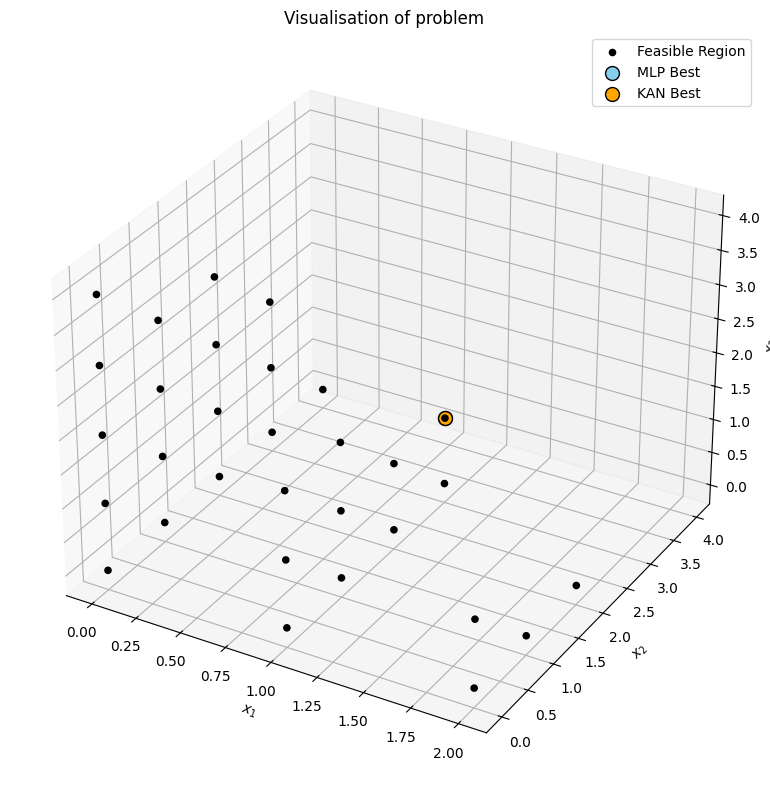

In [52]:
A = np.array([[2, 3, 1],
              [1, 2, 2],
              [3, 1, 2]])
b = np.array([12, 10, 8])

x1Vals = np.arange(0, 11)
x2Vals = np.arange(0, 11)
x3Vals = np.arange(0, 11)
feasible_points = []
for x1 in x1Vals:
    for x2 in x2Vals:
        for x3 in x3Vals:
            x = np.array([x1, x2, x3])
            if np.all(A @ x <= b):
                feasible_points.append(x)

feasible_points = np.array(feasible_points)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(feasible_points[:, 0], feasible_points[:, 1], feasible_points[:, 2],
           color='black', s=20, alpha=1, label='Feasible Region')
mlpBestX = np.array([mlpBestX1, mlpBestX2, mlpBestX3])
kanBestX = np.array([kanBestX1, kanBestX2, kanBestX3])
ax.scatter(*mlpBestX, color='skyblue', s=100, edgecolor='black', label='MLP Best')
ax.scatter(*kanBestX, color='orange', s=100, edgecolor='black', label='KAN Best')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$x_3$')
ax.set_title('Visualisation of problem')
ax.legend()
plt.tight_layout()
plt.show()
